In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from scipy.sparse import vstack

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
import seaborn as sns

import pickle
import os

In [2]:
# set path to results
path_results = "covid_results"

if not os.path.exists(path_results):
    os.makedirs(path_results)

# Subset disease datasets

In [14]:
path = "C:/Users/SG/hlca_full.h5ad"
adata = anndata.read_h5ad(path, backed = 'r')

In [21]:
set(adata.obs["disease"])

{'COVID-19',
 'chronic obstructive pulmonary disease',
 'chronic rhinitis',
 'cystic fibrosis',
 'hypersensitivity pneumonitis',
 'interstitial lung disease',
 'lung adenocarcinoma',
 'lung large cell carcinoma',
 'lymphangioleiomyomatosis',
 'non-specific interstitial pneumonia',
 'normal',
 'pleomorphic carcinoma',
 'pneumonia',
 'pulmonary fibrosis',
 'pulmonary sarcoidosis',
 'squamous cell lung carcinoma'}

#### Chronic Rhinitis

In [18]:
chronic_rhinitis = adata[adata.obs["disease"] == 'chronic rhinitis'].to_memory()

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


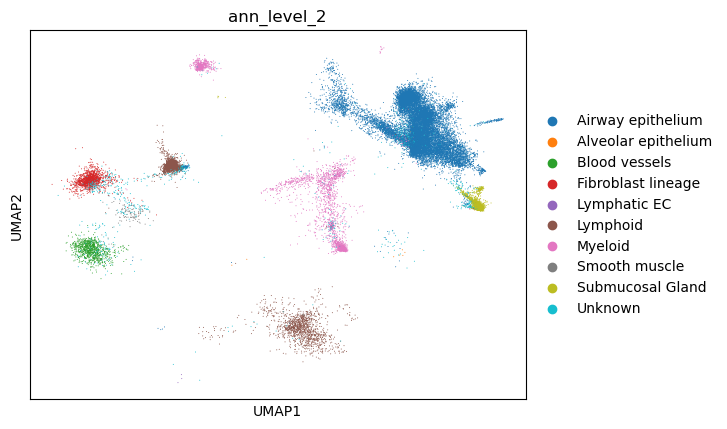

In [29]:
sc.pl.umap(chronic_rhinitis, color=["ann_level_2"], legend_loc="right margin", legend_fontsize = 10, size = 2)

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


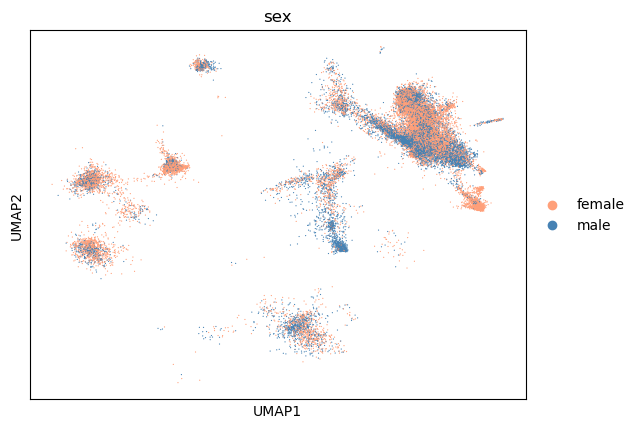

In [20]:
sex_color_map = {'male': 'steelblue', 'female': 'lightsalmon'}
sc.pl.umap(chronic_rhinitis, color="sex", legend_loc="right margin", legend_fontsize=10, size=3, palette=sex_color_map)

In [ ]:
chronic_rhinitis.write('chronic_rhinitis.h5ad')

#### COVID-19

In [25]:
covid = adata[(adata.obs["disease"] == 'COVID-19') & (adata.obs["sex"] != 'unknown')].to_memory()

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


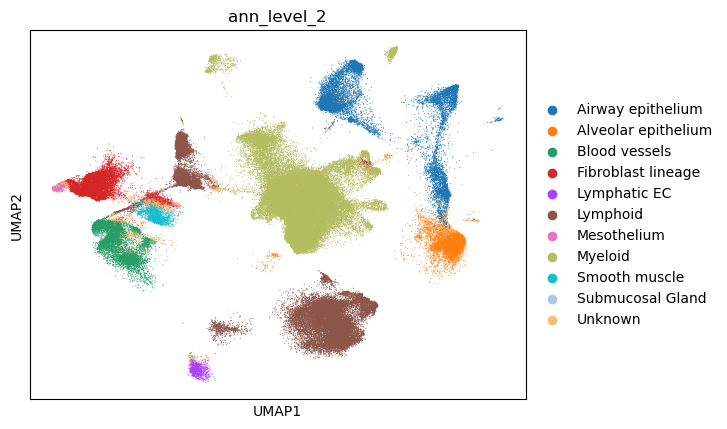

In [28]:
sc.pl.umap(covid, color=["ann_level_2"], legend_loc="right margin", legend_fontsize = 10, size = 2)

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


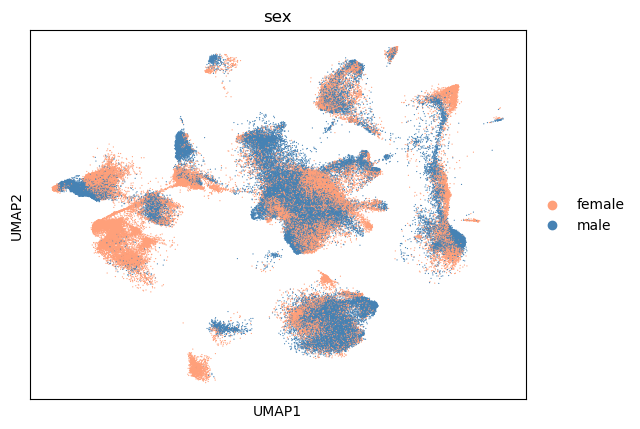

In [33]:
sc.pl.umap(covid, color="sex", legend_loc="right margin", legend_fontsize=10, size=3, palette=sex_color_map)

#### Interstitial lung disease

In [30]:
ILD = adata[(adata.obs["disease"] == 'interstitial lung disease') & (adata.obs["sex"] != 'unknown')].to_memory()

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


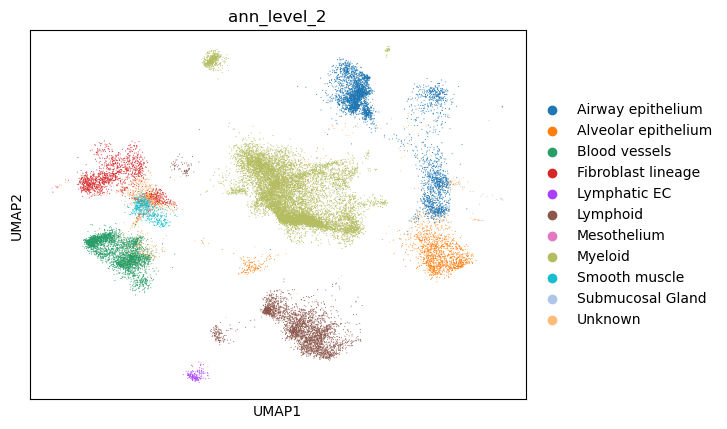

In [31]:
sc.pl.umap(ILD, color=["ann_level_2"], legend_loc="right margin", legend_fontsize = 10, size = 2)

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


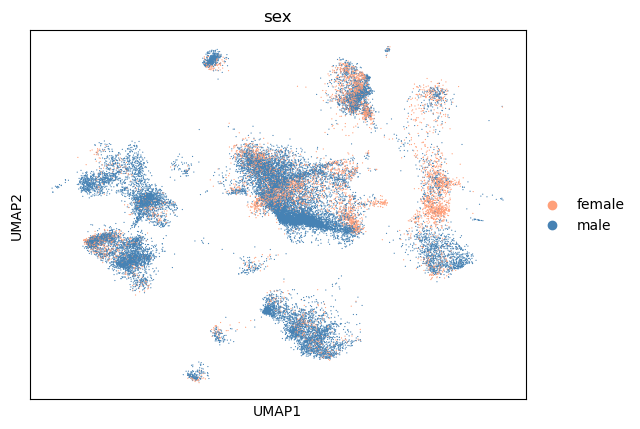

In [32]:
sc.pl.umap(ILD, color="sex", legend_loc="right margin", legend_fontsize=10, size=3, palette=sex_color_map)

#### Remove unknown cells at level 2, save to disk

In [37]:
chronic_rhinitis = chronic_rhinitis[chronic_rhinitis.obs["ann_level_2"] != 'Unknown']
covid = covid[covid.obs["ann_level_2"] != 'Unknown']
ILD = ILD[ILD.obs["ann_level_2"] != 'Unknown']

In [43]:
chronic_rhinitis.write('/Users/SG/Desktop/facultate/YEAR 3/BEP/DATA/chronic_rhinitis.h5ad')
covid.write('/Users/SG/Desktop/facultate/YEAR 3/BEP/DATA/covid_19.h5ad')
ILD.write('/Users/SG/Desktop/facultate/YEAR 3/BEP/DATA/ild.h5ad')

# Pre-process disease datasets

#### Helper functions for checking proportions

In [3]:
def preprocess(adata, level):
    '''
    Removes all cell types with less than 20 cells overall or more than 90% of cells coming from the same sex.
    '''
    to_remove = []
    for cell_type in set(adata.obs[level]):
        count = len(adata[adata.obs[level] == cell_type])
        if count < 20:
            print(f'{cell_type} removed due to low count ({count})')
            to_remove.append(cell_type)
            continue
        female_prop = len(adata[(adata.obs[level] == cell_type) & (adata.obs["sex"] == 'female')])/count
        male_prop = 1 - female_prop
        if male_prop > 0.9 or female_prop > 0.9:
            print(f'{cell_type} removed due to skewed sex ratio ({"%.2f" % male_prop} - {"%.2f" % female_prop})')
            to_remove.append(cell_type)

    return adata[~adata.obs[level].isin(to_remove)], to_remove

In [4]:
def small_train_clf_and_predict(X, y, sex_labels, proportion_female, classifier='knn', k = 30):
    '''
    Reduced version of the final_train_clf_and_predict function that only selects the train and test set, without actually training or predicting.
    '''
    
    np.random.seed(42)

    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]

    X_male = X[male_indices]
    y_male = y[male_indices]
    X_female = X[female_indices]
    y_female = y[female_indices]
    
    
    X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(
        X_female, y_female, test_size=0.2, stratify=y_female, random_state=42)
    
    # compute what to pass to test_size to get equal test set size to the female set
    male_proportion = len(X_female_test) / len(X_male)

    X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(
        X_male, y_male, test_size=male_proportion, stratify=y_male, random_state=42)
    

    # merge training sets back together
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]


    # Select female cells based on proportion_female
    selected_indices = fixed_select_indices_by_proportion(sex_labels_train, proportion_female)
    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]



def small_train(adata, level):
    '''
    Checks if train-test split works.
    '''
    embedding = adata.obsm['X_scanvi_emb']
    sex_labels = adata.obs['sex']
    if level == 2:
        cell_type_labels = adata.obs.ann_level_2
    elif level == 3:
        cell_type_labels = adata.obs['ann_level_3'].astype(str)
        cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_2'].astype(str))
    elif level == 4:
        cell_type_labels = adata.obs['ann_level_4'].astype(str)
        cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_3'].astype(str))
        cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_2'].astype(str))
    else:
        cell_type_labels = adata.obs['ann_finest_level'].astype(str)
    classes = sorted(list(set(cell_type_labels)))

    for prop in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        small_train_clf_and_predict(embedding, cell_type_labels, sex_labels, prop)
        print(f'proportion {prop} ran w/o errors!')

In [5]:
def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    np.random.seed(42)
    sex_labels_series = pd.Series( (el for el in sex_labels) )
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
        # total will always be fixed_size
        # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])

## Check proportions COVID:

In [6]:
path = 'C:/Users/SG/covid.h5ad'
adata = anndata.read_h5ad(path, backed = 'r')

In [13]:
# remove SMG cells, lymphatic EC and blood vessels; then write again to disk
adata = adata[(adata.obs["ann_level_2"] != 'Submucosal Gland') & (adata.obs["ann_level_2"] != 'Lymphatic EC') & (adata.obs["ann_level_2"] != 'Blood vessels')]
adata.write('C:/Users/SG/covid.h5ad')

In [6]:
for cell_type in set(adata.obs["ann_level_2"]):
    count = len(adata[adata.obs["ann_level_2"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_level_2"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Fibroblast lineage: 17386 cells, of which: 0.59 female, 0.41 male
Airway epithelium: 11365 cells, of which: 0.58 female, 0.42 male
Myeloid: 79179 cells, of which: 0.43 female, 0.57 male
Smooth muscle: 1803 cells, of which: 0.44 female, 0.56 male
Mesothelium: 1185 cells, of which: 0.55 female, 0.45 male
Lymphoid: 37661 cells, of which: 0.39 female, 0.61 male
Alveolar epithelium: 6413 cells, of which: 0.39 female, 0.61 male


In [7]:
small_train(adata,2)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


#### Level 3:

In [8]:
print("Before replacement:")
mask = adata.obs['ann_level_3'].isnull() | (adata.obs['ann_level_3'] == 'Unknown')
print(f'{len(adata.obs[mask])} unknown or nan cells')

# Perform the replacement
adata.obs['ann_level_3'] = adata.obs['ann_level_3'].astype('object')
adata.obs.loc[mask, 'ann_level_3'] = adata.obs.loc[mask, 'ann_level_2']
adata.obs['ann_level_3'] = adata.obs['ann_level_3'].astype('category')

# After the replacement
print("\nAfter replacement:")
for cell_type in set(adata.obs["ann_level_3"]):
    count = len(adata[adata.obs["ann_level_3"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_level_3"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Before replacement:
32769 unknown or nan cells

After replacement:
Innate lymphoid cell NK: 164 cells, of which: 0.56 female, 0.44 male
SM activated stress response: 97 cells, of which: 0.99 female, 0.01 male
Smooth muscle: 1704 cells, of which: 0.41 female, 0.59 male
Myeloid: 27184 cells, of which: 0.41 female, 0.59 male
Secretory: 2175 cells, of which: 0.51 female, 0.49 male
Monocytes: 10340 cells, of which: 0.33 female, 0.67 male
Mast cells: 546 cells, of which: 0.47 female, 0.53 male
Macrophages: 37189 cells, of which: 0.47 female, 0.53 male
Fibroblasts: 16814 cells, of which: 0.59 female, 0.41 male
Multiciliated lineage: 5846 cells, of which: 0.54 female, 0.46 male
T cell lineage: 20884 cells, of which: 0.27 female, 0.73 male
Fibroblast lineage: 548 cells, of which: 0.75 female, 0.25 male
Alveolar epithelium: 272 cells, of which: 0.29 female, 0.71 male
Basal: 2697 cells, of which: 0.74 female, 0.26 male
Rare: 57 cells, of which: 0.32 female, 0.68 male
B cell lineage: 15327 cells, 

In [9]:
adata3, to_remove3 = preprocess(adata, "ann_level_3")
print(to_remove3)

SM activated stress response removed due to skewed sex ratio (0.01 - 0.99)
Smooth muscle FAM83D+ removed due to low count (2)
Myofibroblasts removed due to skewed sex ratio (0.04 - 0.96)
['SM activated stress response', 'Smooth muscle FAM83D+', 'Myofibroblasts']


In [10]:
small_train(adata3, 3)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


#### Level 4:

In [11]:
print("Before replacement:")
mask = adata.obs['ann_level_4'].isnull() | (adata.obs['ann_level_4'] == 'Unknown')
print(f'{len(adata.obs[mask])} unknown or nan cells')

# Perform the replacement
adata.obs['ann_level_4'] = adata.obs['ann_level_4'].astype('object')
adata.obs.loc[mask, 'ann_level_4'] = adata.obs.loc[mask, 'ann_level_3']
adata.obs.loc[mask, 'ann_level_4'] = adata.obs.loc[mask, 'ann_level_2']
adata.obs['ann_level_4'] = adata.obs['ann_level_4'].astype('category')

# After the replacement
print("\nAfter replacement:")
for cell_type in set(adata.obs["ann_level_4"]):
    count = len(adata[adata.obs["ann_level_4"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_level_4"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Before replacement:
78902 unknown or nan cells

After replacement:
Basal resting: 376 cells, of which: 0.74 female, 0.26 male
DC2: 1501 cells, of which: 0.35 female, 0.65 male
Peribronchial fibroblasts: 2574 cells, of which: 0.77 female, 0.23 male
CD4 T cells: 5792 cells, of which: 0.22 female, 0.78 male
Smooth muscle: 1803 cells, of which: 0.44 female, 0.56 male
Interstitial macrophages: 12974 cells, of which: 0.63 female, 0.37 male
Myeloid: 48223 cells, of which: 0.42 female, 0.58 male
Non-classical monocytes: 3213 cells, of which: 0.20 female, 0.80 male
Adventitial fibroblasts: 440 cells, of which: 0.33 female, 0.67 male
Club: 292 cells, of which: 0.11 female, 0.89 male
AT2 proliferating: 13 cells, of which: 0.08 female, 0.92 male
Tuft: 1 cells, of which: 1.00 female, 0.00 male
Deuterosomal: 149 cells, of which: 0.44 female, 0.56 male
Suprabasal: 1005 cells, of which: 0.66 female, 0.34 male
Plasmacytoid DCs: 1232 cells, of which: 0.62 female, 0.38 male
Goblet: 158 cells, of which: 0

In [12]:
adata4, to_remove4 = preprocess(adata, "ann_level_4")
print(to_remove4)

AT2 proliferating removed due to low count (13)
Tuft removed due to low count (1)
Goblet removed due to skewed sex ratio (0.08 - 0.92)
Alveolar fibroblasts removed due to skewed sex ratio (0.01 - 0.99)
Neuroendocrine removed due to low count (3)
Subpleural fibroblasts removed due to skewed sex ratio (0.98 - 0.02)
['AT2 proliferating', 'Tuft', 'Goblet', 'Alveolar fibroblasts', 'Neuroendocrine', 'Subpleural fibroblasts']


In [13]:
small_train(adata4, 4)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


#### Level 5:

In [14]:
print("Before replacement:")
mask = (adata.obs['ann_finest_level'] == 'Unknown')
print(f'{len(adata.obs[mask])} unknown cells')

# Perform the replacement
adata.obs['ann_finest_level'] = adata.obs['ann_finest_level'].astype('object')
adata.obs.loc[mask, 'ann_finest_level'] = adata.obs.loc[mask, 'ann_level_4']
adata.obs.loc[mask, 'ann_finest_level'] = adata.obs.loc[mask, 'ann_level_3']
adata.obs.loc[mask, 'ann_finest_level'] = adata.obs.loc[mask, 'ann_level_2']
adata.obs['ann_finest_level'] = adata.obs['ann_finest_level'].astype('category')

# After the replacement
print("\nAfter replacement:")
for cell_type in set(adata.obs["ann_finest_level"]):
    count = len(adata[adata.obs["ann_finest_level"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_finest_level"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Before replacement:
75529 unknown cells

After replacement:
SM activated stress response: 97 cells, of which: 0.99 female, 0.01 male
Basal resting: 376 cells, of which: 0.74 female, 0.26 male
DC2: 1501 cells, of which: 0.35 female, 0.65 male
Peribronchial fibroblasts: 2574 cells, of which: 0.77 female, 0.23 male
CD4 T cells: 5792 cells, of which: 0.22 female, 0.78 male
Goblet (subsegmental): 3 cells, of which: 0.67 female, 0.33 male
Smooth muscle: 1704 cells, of which: 0.41 female, 0.59 male
Myeloid: 52927 cells, of which: 0.43 female, 0.57 male
Club (nasal): 1 cells, of which: 1.00 female, 0.00 male
Non-classical monocytes: 3213 cells, of which: 0.20 female, 0.80 male
Adventitial fibroblasts: 440 cells, of which: 0.33 female, 0.67 male
Interstitial Mph perivascular: 375 cells, of which: 0.83 female, 0.17 male
Multiciliated (non-nasal): 5403 cells, of which: 0.52 female, 0.48 male
AT2 proliferating: 13 cells, of which: 0.08 female, 0.92 male
Tuft: 1 cells, of which: 1.00 female, 0.00 m

In [15]:
adata5, to_remove5 = preprocess(adata, "ann_finest_level")
to_remove5

SM activated stress response removed due to skewed sex ratio (0.01 - 0.99)
Goblet (subsegmental) removed due to low count (3)
Club (nasal) removed due to low count (1)
AT2 proliferating removed due to low count (13)
Tuft removed due to low count (1)
Goblet (nasal) removed due to low count (19)
Goblet (bronchial) removed due to skewed sex ratio (0.03 - 0.97)
Alveolar fibroblasts removed due to skewed sex ratio (0.01 - 0.99)
Smooth muscle FAM83D+ removed due to low count (2)
Myofibroblasts removed due to skewed sex ratio (0.04 - 0.96)
Neuroendocrine removed due to low count (3)
Subpleural fibroblasts removed due to skewed sex ratio (0.98 - 0.02)
Multiciliated (nasal) removed due to low count (3)


['SM activated stress response',
 'Goblet (subsegmental)',
 'Club (nasal)',
 'AT2 proliferating',
 'Tuft',
 'Goblet (nasal)',
 'Goblet (bronchial)',
 'Alveolar fibroblasts',
 'Smooth muscle FAM83D+',
 'Myofibroblasts',
 'Neuroendocrine',
 'Subpleural fibroblasts',
 'Multiciliated (nasal)']

In [16]:
small_train(adata5, 5)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


Uncomment this to save the anndata objectwith pre-processing performed at the finest level:

In [17]:
# adata5.write(f'{path_results}/covid_finest.h5ad')

### save cell names to dictionary for later use:

In [18]:
def create_cellnames_dict(adata, to_remove3, to_remove4, to_remove5, disease):
    # save processed cell names
    ann2 = list(set(adata.obs.ann_level_2))
    
    ann3 = list(set(adata.obs.ann_level_3).difference(set(to_remove3)))
    ann3 = [x for x in ann3 if (not (isinstance(x, (int, float)) and np.isnan(x)) and x != 'Unknown')]
    
    ann4 = list(set(adata.obs.ann_level_4).difference(set(to_remove4)))
    ann4 = [x for x in ann4 if (not (isinstance(x, (int, float)) and np.isnan(x)) and x != 'Unknown')]

    ann5 = list(set(adata.obs.ann_finest_level).difference(set(to_remove5)))
    ann5 = [x for x in ann5 if (not (isinstance(x, (int, float)) and np.isnan(x)) and x != 'Unknown')]

    # create dict
    cell_names = {
        'ann_finest': ann5,
        'ann_4': ann4,
        'ann_3': ann3,
        'ann_2': ann2
    }

    # save
    with open(f'{path_results}/cell_names_{disease}.pickle', 'wb') as file:
        pickle.dump(cell_names, file)

In [19]:
create_cellnames_dict(adata, to_remove3, to_remove4, to_remove5, 'covid')

## Check proportions chronic rhinitidis

In [20]:
path = 'C:/Users/SG/chronic_rhinitis.h5ad'
adata = anndata.read_h5ad(path)

In [12]:
for cell_type in set(adata.obs["ann_level_2"]):
    count = len(adata[adata.obs["ann_level_2"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_level_2"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Lymphoid: 4015 cells, of which: 0.68 female, 0.32 male
Lymphatic EC: 3 cells, of which: 0.67 female, 0.33 male
Alveolar epithelium: 10 cells, of which: 1.00 female, 0.00 male
Blood vessels: 903 cells, of which: 0.72 female, 0.28 male
Airway epithelium: 17176 cells, of which: 0.57 female, 0.43 male
Fibroblast lineage: 1347 cells, of which: 0.67 female, 0.33 male
Smooth muscle: 111 cells, of which: 0.69 female, 0.31 male
Myeloid: 2296 cells, of which: 0.35 female, 0.65 male
Submucosal Gland: 1914 cells, of which: 0.96 female, 0.04 male


In [13]:
# remove Lymphatic EC, Alveolar epithelium cells; then write again to disk
adata = adata[(adata.obs["ann_level_2"] != 'Lymphatic EC') & (adata.obs["ann_level_2"] != 'Alveolar epithelium')]
adata.write('C:/Users/SG/chronic_rhinitis.h5ad')

In [21]:
small_train(adata, 2)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


#### Level 3

In [22]:
print("Before replacement:")
mask = adata.obs['ann_level_3'].isnull() | (adata.obs['ann_level_3'] == 'Unknown')
print(f'{len(adata.obs[mask])} unknown or nan cells')

# Perform the replacement
adata.obs['ann_level_3'] = adata.obs['ann_level_3'].astype('object')
adata.obs.loc[mask, 'ann_level_3'] = adata.obs.loc[mask, 'ann_level_2']
adata.obs['ann_level_3'] = adata.obs['ann_level_3'].astype('category')

# After the replacement
print("\nAfter replacement:")
for cell_type in set(adata.obs["ann_level_3"]):
    count = len(adata[adata.obs["ann_level_3"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_level_3"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Before replacement:
4006 unknown or nan cells

After replacement:
Innate lymphoid cell NK: 50 cells, of which: 0.60 female, 0.40 male
Smooth muscle: 111 cells, of which: 0.69 female, 0.31 male
Myeloid: 568 cells, of which: 0.32 female, 0.68 male
EC arterial: 30 cells, of which: 0.80 female, 0.20 male
Secretory: 6136 cells, of which: 0.45 female, 0.55 male
Monocytes: 634 cells, of which: 0.15 female, 0.85 male
Mast cells: 508 cells, of which: 0.41 female, 0.59 male
Fibroblasts: 1258 cells, of which: 0.66 female, 0.34 male
Macrophages: 161 cells, of which: 0.34 female, 0.66 male
Multiciliated lineage: 1079 cells, of which: 0.53 female, 0.47 male
EC venous: 660 cells, of which: 0.72 female, 0.28 male
T cell lineage: 1216 cells, of which: 0.50 female, 0.50 male
Fibroblast lineage: 88 cells, of which: 0.78 female, 0.22 male
EC capillary: 3 cells, of which: 0.33 female, 0.67 male
Blood vessels: 210 cells, of which: 0.71 female, 0.29 male
Basal: 6973 cells, of which: 0.69 female, 0.31 male
Ra

In [23]:
adata3, to_remove3 = preprocess(adata, "ann_level_3")
to_remove3

EC capillary removed due to low count (3)
Submucosal Secretory removed due to skewed sex ratio (0.04 - 0.96)
Myofibroblasts removed due to low count (1)


['EC capillary', 'Submucosal Secretory', 'Myofibroblasts']

In [24]:
small_train(adata3, 3)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


#### Level 4

In [25]:
print("Before replacement:")
mask = adata.obs['ann_level_4'].isnull() | (adata.obs['ann_level_4'] == 'Unknown')
print(f'{len(adata.obs[mask])} unknown or nan cells')

# Perform the replacement
adata.obs['ann_level_4'] = adata.obs['ann_level_4'].astype('object')
adata.obs.loc[mask, 'ann_level_4'] = adata.obs.loc[mask, 'ann_level_3']
adata.obs.loc[mask, 'ann_level_4'] = adata.obs.loc[mask, 'ann_level_2']
adata.obs['ann_level_4'] = adata.obs['ann_level_4'].astype('category')

# After the replacement
print("\nAfter replacement:")
for cell_type in set(adata.obs["ann_level_4"]):
    count = len(adata[adata.obs["ann_level_4"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_level_4"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Before replacement:
10868 unknown or nan cells

After replacement:
Basal resting: 3207 cells, of which: 0.67 female, 0.33 male
DC2: 394 cells, of which: 0.61 female, 0.39 male
Peribronchial fibroblasts: 158 cells, of which: 0.76 female, 0.24 male
CD4 T cells: 126 cells, of which: 0.56 female, 0.44 male
EC general capillary: 1 cells, of which: 1.00 female, 0.00 male
Smooth muscle: 111 cells, of which: 0.69 female, 0.31 male
Interstitial macrophages: 144 cells, of which: 0.36 female, 0.64 male
Myeloid: 1148 cells, of which: 0.36 female, 0.64 male
Non-classical monocytes: 7 cells, of which: 0.71 female, 0.29 male
Adventitial fibroblasts: 58 cells, of which: 0.64 female, 0.36 male
Club: 1367 cells, of which: 0.64 female, 0.36 male
Tuft: 8 cells, of which: 0.62 female, 0.38 male
Deuterosomal: 51 cells, of which: 0.47 female, 0.53 male
Suprabasal: 2144 cells, of which: 0.71 female, 0.29 male
Plasmacytoid DCs: 9 cells, of which: 0.33 female, 0.67 male
Goblet: 1780 cells, of which: 0.31 female

In [26]:
adata4, to_remove4 = preprocess(adata, "ann_level_4")
to_remove4

EC general capillary removed due to low count (1)
Non-classical monocytes removed due to low count (7)
Tuft removed due to low count (8)
Plasmacytoid DCs removed due to low count (9)
Migratory DCs removed due to low count (1)
SMG mucous removed due to skewed sex ratio (0.01 - 0.99)
Hillock-like removed due to low count (4)
Submucosal Gland removed due to skewed sex ratio (0.08 - 0.92)
DC1 removed due to low count (4)
Pericytes removed due to low count (6)
Alveolar fibroblasts removed due to low count (8)
EC venous pulmonary removed due to skewed sex ratio (0.05 - 0.95)
T cells proliferating removed due to low count (8)
Alveolar macrophages removed due to low count (3)
Subpleural fibroblasts removed due to low count (1)
SMG serous removed due to skewed sex ratio (0.03 - 0.97)


['EC general capillary',
 'Non-classical monocytes',
 'Tuft',
 'Plasmacytoid DCs',
 'Migratory DCs',
 'SMG mucous',
 'Hillock-like',
 'Submucosal Gland',
 'DC1',
 'Pericytes',
 'Alveolar fibroblasts',
 'EC venous pulmonary',
 'T cells proliferating',
 'Alveolar macrophages',
 'Subpleural fibroblasts',
 'SMG serous']

In [27]:
print("Before replacement:")
mask = (adata.obs['ann_finest_level'] == 'Unknown')
print(f'{len(adata.obs[mask])} unknown cells')

# Perform the replacement
adata.obs['ann_finest_level'] = adata.obs['ann_finest_level'].astype('object')
adata.obs.loc[mask, 'ann_finest_level'] = adata.obs.loc[mask, 'ann_level_4']
adata.obs.loc[mask, 'ann_finest_level'] = adata.obs.loc[mask, 'ann_level_3']
adata.obs.loc[mask, 'ann_finest_level'] = adata.obs.loc[mask, 'ann_level_2']
adata.obs['ann_finest_level'] = adata.obs['ann_finest_level'].astype('category')

# After the replacement
print("\nAfter replacement:")
for cell_type in set(adata.obs["ann_finest_level"]):
    count = len(adata[adata.obs["ann_finest_level"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_finest_level"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Before replacement:
11183 unknown cells

After replacement:
Basal resting: 3207 cells, of which: 0.67 female, 0.33 male
SMG serous (nasal): 982 cells, of which: 0.98 female, 0.02 male
DC2: 394 cells, of which: 0.61 female, 0.39 male
Peribronchial fibroblasts: 158 cells, of which: 0.76 female, 0.24 male
CD4 T cells: 126 cells, of which: 0.56 female, 0.44 male
EC general capillary: 1 cells, of which: 1.00 female, 0.00 male
Smooth muscle: 111 cells, of which: 0.69 female, 0.31 male
Myeloid: 683 cells, of which: 0.32 female, 0.68 male
Club (nasal): 946 cells, of which: 0.65 female, 0.35 male
EC arterial: 30 cells, of which: 0.80 female, 0.20 male
Non-classical monocytes: 7 cells, of which: 0.71 female, 0.29 male
Adventitial fibroblasts: 58 cells, of which: 0.64 female, 0.36 male
Interstitial Mph perivascular: 44 cells, of which: 0.59 female, 0.41 male
Multiciliated (non-nasal): 879 cells, of which: 0.57 female, 0.43 male
Tuft: 8 cells, of which: 0.62 female, 0.38 male
Mast cells: 508 cells

In [28]:
adata5, to_remove5 = preprocess(adata, "ann_finest_level")
to_remove5

SMG serous (nasal) removed due to skewed sex ratio (0.02 - 0.98)
EC general capillary removed due to low count (1)
Non-classical monocytes removed due to low count (7)
Tuft removed due to low count (8)
Plasmacytoid DCs removed due to low count (9)
Alveolar Mph CCL3+ removed due to low count (1)
Migratory DCs removed due to low count (1)
SMG mucous removed due to skewed sex ratio (0.01 - 0.99)
Hillock-like removed due to low count (4)
Submucosal Gland removed due to skewed sex ratio (0.06 - 0.94)
DC1 removed due to low count (4)
SMG serous (bronchial) removed due to skewed sex ratio (0.04 - 0.96)
Goblet (bronchial) removed due to low count (2)
Alveolar fibroblasts removed due to low count (8)
EC venous pulmonary removed due to skewed sex ratio (0.05 - 0.95)
T cells proliferating removed due to low count (8)
Alveolar macrophages removed due to low count (2)
Myofibroblasts removed due to low count (1)
Subpleural fibroblasts removed due to low count (1)
Pericytes removed due to low count (

['SMG serous (nasal)',
 'EC general capillary',
 'Non-classical monocytes',
 'Tuft',
 'Plasmacytoid DCs',
 'Alveolar Mph CCL3+',
 'Migratory DCs',
 'SMG mucous',
 'Hillock-like',
 'Submucosal Gland',
 'DC1',
 'SMG serous (bronchial)',
 'Goblet (bronchial)',
 'Alveolar fibroblasts',
 'EC venous pulmonary',
 'T cells proliferating',
 'Alveolar macrophages',
 'Myofibroblasts',
 'Subpleural fibroblasts',
 'Pericytes',
 'Multiciliated (nasal)']

Uncomment this to save the anndata objectwith pre-processing performed at the finest level:

In [29]:
# adata5.write(f'{path_results}/chronic_rhinitis_finest.h5ad')

## Check proportions interstitial lung disease

In [30]:
path = 'C:/Users/SG/ild.h5ad'
adata = anndata.read_h5ad(path)

In [27]:
for cell_type in set(adata.obs["ann_level_2"]):
    count = len(adata[adata.obs["ann_level_2"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_level_2"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Alveolar epithelium: 1289 cells, of which: 0.16 female, 0.84 male
Fibroblast lineage: 1494 cells, of which: 0.07 female, 0.93 male
Lymphatic EC: 159 cells, of which: 0.19 female, 0.81 male
Blood vessels: 3070 cells, of which: 0.17 female, 0.83 male
Mesothelium: 8 cells, of which: 0.00 female, 1.00 male
Submucosal Gland: 15 cells, of which: 0.13 female, 0.87 male
Myeloid: 12273 cells, of which: 0.21 female, 0.79 male
Lymphoid: 3053 cells, of which: 0.11 female, 0.89 male
Smooth muscle: 634 cells, of which: 0.13 female, 0.87 male
Airway epithelium: 4022 cells, of which: 0.53 female, 0.47 male


In [28]:
# remove Submucosal Gland, Fibroblast lineage and Mesothelium cells; then write again to disk
adata = adata[(adata.obs["ann_level_2"] != 'Submucosal Gland') & (adata.obs["ann_level_2"] != 'Fibroblast lineage') & (adata.obs["ann_level_2"] != 'Mesothelium')]
adata.write('/Users/SG/Desktop/facultate/YEAR 3/BEP/DATA/ild.h5ad')

In [31]:
small_train(adata, 2)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


#### Level 3

In [32]:
print("Before replacement:")
mask = adata.obs['ann_level_3'].isnull() | (adata.obs['ann_level_3'] == 'Unknown')
print(f'{len(adata.obs[mask])} unknown or nan cells')

# Perform the replacement
adata.obs['ann_level_3'] = adata.obs['ann_level_3'].astype('object')
adata.obs.loc[mask, 'ann_level_3'] = adata.obs.loc[mask, 'ann_level_2']
adata.obs['ann_level_3'] = adata.obs['ann_level_3'].astype('category')

# After the replacement
print("\nAfter replacement:")
for cell_type in set(adata.obs["ann_level_3"]):
    count = len(adata[adata.obs["ann_level_3"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_level_3"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Before replacement:
3156 unknown or nan cells

After replacement:
Innate lymphoid cell NK: 510 cells, of which: 0.07 female, 0.93 male
SM activated stress response: 9 cells, of which: 0.56 female, 0.44 male
Smooth muscle: 624 cells, of which: 0.12 female, 0.88 male
Myeloid: 1487 cells, of which: 0.21 female, 0.79 male
EC arterial: 167 cells, of which: 0.13 female, 0.87 male
Secretory: 927 cells, of which: 0.76 female, 0.24 male
Monocytes: 1205 cells, of which: 0.37 female, 0.63 male
Mast cells: 490 cells, of which: 0.16 female, 0.84 male
Macrophages: 8689 cells, of which: 0.17 female, 0.83 male
Multiciliated lineage: 2451 cells, of which: 0.42 female, 0.58 male
EC venous: 1190 cells, of which: 0.28 female, 0.72 male
T cell lineage: 2194 cells, of which: 0.12 female, 0.88 male
Lymphatic EC: 27 cells, of which: 0.11 female, 0.89 male
Lymphatic EC mature: 130 cells, of which: 0.21 female, 0.79 male
EC capillary: 1169 cells, of which: 0.07 female, 0.93 male
Blood vessels: 544 cells, of whi

In [33]:
adata3, to_remove3 = preprocess(adata, "ann_level_3")
to_remove3

Innate lymphoid cell NK removed due to skewed sex ratio (0.93 - 0.07)
SM activated stress response removed due to low count (9)
EC capillary removed due to skewed sex ratio (0.93 - 0.07)
Rare removed due to low count (2)
Smooth muscle FAM83D+ removed due to low count (1)
Lymphoid removed due to skewed sex ratio (0.96 - 0.04)
Lymphatic EC differentiating removed due to low count (2)


['Innate lymphoid cell NK',
 'SM activated stress response',
 'EC capillary',
 'Rare',
 'Smooth muscle FAM83D+',
 'Lymphoid',
 'Lymphatic EC differentiating']

In [34]:
small_train(adata3, 3)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


#### Level 4

In [35]:
print("Before replacement:")
mask = adata.obs['ann_level_4'].isnull() | (adata.obs['ann_level_4'] == 'Unknown')
print(f'{len(adata.obs[mask])} unknown or nan cells')

# Perform the replacement
adata.obs['ann_level_4'] = adata.obs['ann_level_4'].astype('object')
adata.obs.loc[mask, 'ann_level_4'] = adata.obs.loc[mask, 'ann_level_3']
adata.obs.loc[mask, 'ann_level_4'] = adata.obs.loc[mask, 'ann_level_2']
adata.obs['ann_level_4'] = adata.obs['ann_level_4'].astype('category')

# After the replacement
print("\nAfter replacement:")
for cell_type in set(adata.obs["ann_level_4"]):
    count = len(adata[adata.obs["ann_level_4"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_level_4"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Before replacement:
9087 unknown or nan cells

After replacement:
Basal resting: 135 cells, of which: 0.55 female, 0.45 male
DC2: 347 cells, of which: 0.53 female, 0.47 male
EC general capillary: 818 cells, of which: 0.05 female, 0.95 male
CD4 T cells: 990 cells, of which: 0.11 female, 0.89 male
Smooth muscle: 634 cells, of which: 0.13 female, 0.87 male
Interstitial macrophages: 3980 cells, of which: 0.13 female, 0.87 male
Myeloid: 4191 cells, of which: 0.21 female, 0.79 male
Non-classical monocytes: 106 cells, of which: 0.63 female, 0.37 male
Club: 66 cells, of which: 0.79 female, 0.21 male
AT2 proliferating: 7 cells, of which: 0.00 female, 1.00 male
Deuterosomal: 3 cells, of which: 0.33 female, 0.67 male
Suprabasal: 48 cells, of which: 0.69 female, 0.31 male
Lymphatic EC: 159 cells, of which: 0.19 female, 0.81 male
Plasmacytoid DCs: 27 cells, of which: 0.26 female, 0.74 male
Goblet: 49 cells, of which: 0.69 female, 0.31 male
Migratory DCs: 7 cells, of which: 0.43 female, 0.57 male
Hi

In [36]:
adata4, to_remove4 = preprocess(adata, "ann_level_4")
to_remove4

EC general capillary removed due to skewed sex ratio (0.95 - 0.05)
AT2 proliferating removed due to low count (7)
Deuterosomal removed due to low count (3)
Migratory DCs removed due to low count (7)
Hillock-like removed due to low count (1)
DC1 removed due to low count (12)
NK cells removed due to skewed sex ratio (0.93 - 0.07)
T cells proliferating removed due to low count (4)
Lymphoid removed due to skewed sex ratio (0.93 - 0.07)
Plasma cells removed due to skewed sex ratio (0.91 - 0.09)
Neuroendocrine removed due to low count (2)


['EC general capillary',
 'AT2 proliferating',
 'Deuterosomal',
 'Migratory DCs',
 'Hillock-like',
 'DC1',
 'NK cells',
 'T cells proliferating',
 'Lymphoid',
 'Plasma cells',
 'Neuroendocrine']

In [37]:
small_train(adata4, 4)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


In [38]:
print("Before replacement:")
mask = (adata.obs['ann_finest_level'] == 'Unknown')
print(f'{len(adata.obs[mask])} unknown cells')

# Perform the replacement
adata.obs['ann_finest_level'] = adata.obs['ann_finest_level'].astype('object')
adata.obs.loc[mask, 'ann_finest_level'] = adata.obs.loc[mask, 'ann_level_4']
adata.obs.loc[mask, 'ann_finest_level'] = adata.obs.loc[mask, 'ann_level_3']
adata.obs.loc[mask, 'ann_finest_level'] = adata.obs.loc[mask, 'ann_level_2']
adata.obs['ann_finest_level'] = adata.obs['ann_finest_level'].astype('category')

# After the replacement
print("\nAfter replacement:")
for cell_type in set(adata.obs["ann_finest_level"]):
    count = len(adata[adata.obs["ann_finest_level"] == cell_type])
    female_prop = len(adata[(adata.obs["ann_finest_level"] == cell_type) & (adata.obs["sex"] == 'female')])/count
    male_prop = 1 - female_prop
    print(f'{cell_type}: {count} cells, of which: {"{:.2f}".format(female_prop)} female, {"{:.2f}".format(male_prop)} male')

Before replacement:
7438 unknown cells

After replacement:
SM activated stress response: 9 cells, of which: 0.56 female, 0.44 male
Basal resting: 135 cells, of which: 0.55 female, 0.45 male
DC2: 347 cells, of which: 0.53 female, 0.47 male
EC general capillary: 818 cells, of which: 0.05 female, 0.95 male
CD4 T cells: 990 cells, of which: 0.11 female, 0.89 male
Smooth muscle: 624 cells, of which: 0.12 female, 0.88 male
Myeloid: 4328 cells, of which: 0.21 female, 0.79 male
EC arterial: 167 cells, of which: 0.13 female, 0.87 male
Non-classical monocytes: 106 cells, of which: 0.63 female, 0.37 male
Interstitial Mph perivascular: 77 cells, of which: 0.03 female, 0.97 male
Multiciliated (non-nasal): 2418 cells, of which: 0.42 female, 0.58 male
AT2 proliferating: 7 cells, of which: 0.00 female, 1.00 male
Mast cells: 490 cells, of which: 0.16 female, 0.84 male
Deuterosomal: 3 cells, of which: 0.33 female, 0.67 male
Suprabasal: 48 cells, of which: 0.69 female, 0.31 male
Lymphatic EC: 27 cells, o

In [39]:
adata5, to_remove5 = preprocess(adata, "ann_finest_level")
to_remove5

SM activated stress response removed due to low count (9)
EC general capillary removed due to skewed sex ratio (0.95 - 0.05)
Interstitial Mph perivascular removed due to skewed sex ratio (0.97 - 0.03)
AT2 proliferating removed due to low count (7)
Deuterosomal removed due to low count (3)
Alveolar Mph CCL3+ removed due to low count (8)
Migratory DCs removed due to low count (7)
Hillock-like removed due to low count (1)
DC1 removed due to low count (12)
Alveolar Mph MT-positive removed due to low count (10)
Goblet (bronchial) removed due to low count (5)
AT0 removed due to skewed sex ratio (0.05 - 0.95)
NK cells removed due to skewed sex ratio (0.93 - 0.07)
T cells proliferating removed due to low count (4)
Smooth muscle FAM83D+ removed due to low count (1)
Lymphoid removed due to skewed sex ratio (0.93 - 0.07)
Plasma cells removed due to skewed sex ratio (0.91 - 0.09)
Neuroendocrine removed due to low count (2)
Lymphatic EC differentiating removed due to low count (2)
Multiciliated (na

['SM activated stress response',
 'EC general capillary',
 'Interstitial Mph perivascular',
 'AT2 proliferating',
 'Deuterosomal',
 'Alveolar Mph CCL3+',
 'Migratory DCs',
 'Hillock-like',
 'DC1',
 'Alveolar Mph MT-positive',
 'Goblet (bronchial)',
 'AT0',
 'NK cells',
 'T cells proliferating',
 'Smooth muscle FAM83D+',
 'Lymphoid',
 'Plasma cells',
 'Neuroendocrine',
 'Lymphatic EC differentiating',
 'Multiciliated (nasal)']

In [40]:
small_train(adata5, 5)

proportion 0 ran w/o errors!
proportion 0.1 ran w/o errors!
proportion 0.2 ran w/o errors!
proportion 0.3 ran w/o errors!
proportion 0.4 ran w/o errors!
proportion 0.5 ran w/o errors!
proportion 0.6 ran w/o errors!
proportion 0.7 ran w/o errors!
proportion 0.8 ran w/o errors!
proportion 0.9 ran w/o errors!
proportion 1 ran w/o errors!


Uncomment this to save the anndata objectwith pre-processing performed at the finest level:

In [41]:
# adata5.write(f'{path_results}/ild_finest.h5ad')